In [19]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SARSA

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1VuWcRMirIhX6u2rt_8a0E2mPSnAQXHl7/SARSA


### SARSA (State-Action-Reward-State-Action) Algorithm Implementation

SARSA is an ON-POLICY Temporal Difference (TD) learning algorithm.

Key Characteristics:
- On-policy: Learns the value of the policy being followed (including exploration)
- TD Learning: Updates estimates based on other estimates (bootstrapping)
- Model-free: Doesn't require knowledge of environment dynamics

Update Rule:
    Q(s,a) ← Q(s,a) + α[r + γQ(s',a') - Q(s,a)]

Where:
    s: current state
    a: action taken from s
    r: reward received
    s': next state
    a': next action (chosen by same policy - KEY DIFFERENCE from Q-learning)
    α: learning rate (how much to update)
    γ: discount factor (importance of future rewards)

Underlying MDP Framework:
- States (S): Grid positions (driver_x, driver_y, dest_x, dest_y)
- Actions (A): {0: Right, 1: Up, 2: Left, 3: Down}
- Transition Function P(s'|s,a): Deterministic grid movement with obstacle collision
- Reward Function R(s,a,s'): Distance-based penalties + goal reward + obstacle penalty
- Policy π(a|s): ε-greedy (exploration vs exploitation trade-off)

In [20]:
import numpy as np
import gymnasium as gym
from Map import MapEnv
from collections import defaultdict
from tqdm import tqdm
from matplotlib import pyplot as plt
from typing import List, Optional

# SARSA LOGIC
- Initialize q-table, learning rate, discount and epsilon
- Convert environment obs into tuple for Q-table
- Implement epsilon greedy (exploration vs exploitation)
- SARSA update
- Gradual shift of epsilon from exploration to exploitation

In [21]:
class SARSAAgent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float,
    ):
        self.env = env
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))
        self.lr = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.training_error = []

    def _obs_to_tuple(self, obs):
        d = obs["driver"]
        dest = obs["destination"]
        return (int(d[0]), int(d[1]), int(dest[0]), int(dest[1]))

    def choose_action(self, obs: tuple[int, int, bool]) -> int:
        obs_tuple = self._obs_to_tuple(obs)
        # Exploration
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
        # Exploitation
            return int(np.argmax(self.q_values[obs_tuple]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
        next_action: int,  # KEY DIFFERENCE: SARSA uses actual next action
    ):
        obs_tuple = self._obs_to_tuple(obs)
        next_obs_tuple = self._obs_to_tuple(next_obs)

        # SARSA: Use actual next action (not max)
        future_q_value = (not terminated) * self.q_values[next_obs_tuple][next_action]
        destination = reward + self.discount_factor * future_q_value
        temporal_difference = destination - self.q_values[obs_tuple][action]

        self.q_values[obs_tuple][action] = (
            self.q_values[obs_tuple][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

# Training and Visualization

In [22]:
def train_agent(agent, env, n_episodes: int, log_interval: int=5000):
    episode_rewards = []
    episode_lengths = []
    epsilon_history = []
    success_rate_history = []

    print(f"\nTraining for {n_episodes} episodes...\n")

    for episode in tqdm(range(n_episodes), desc="Training"):
        obs, info = env.reset()
        done = False
        episode_reward = 0
        steps = 0

        #choose initial action
        action = agent.choose_action(obs)

        while not done:
            next_obs, reward, terminated, truncated, info = env.step(action)

            # choose next action before update
            next_action = agent.choose_action(next_obs)

            #update using actual next action
            agent.update(obs, action, reward, terminated, next_obs, next_action)

            episode_reward += reward
            steps += 1
            done = terminated or truncated
            obs = next_obs
            action = next_action

        agent.decay_epsilon()
        episode_rewards.append(episode_reward)
        episode_lengths.append(steps)
        epsilon_history.append(agent.epsilon)

        if episode >= 99:
            recent_successes = [1 if r > 0 else 0 for r in episode_rewards[-100:]]
            success_rate_history.append(np.mean(recent_successes))

        if (episode + 1) % log_interval == 0:
            recent_rewards = episode_rewards[-1000:]
            tqdm.write(f"\nEpisode {episode + 1}/{n_episodes}")
            tqdm.write(f"  Avg Reward: {np.mean(recent_rewards):.2f}")
            tqdm.write(f"  Success Rate: {np.mean(recent_successes):.1%}")
            tqdm.write(f"  Avg Steps: {np.mean(episode_lengths[-1000:]):.1f}")
            tqdm.write(f"  Epsilon: {agent.epsilon:.4f}")
            tqdm.write(f"  States: {len(agent.q_values)}")

        # success rate over all episodes
    overall_success_rate = np.mean([1 if r > 0 else 0 for r in episode_rewards])

    print(f"\nTraining complete. States explored: {len(agent.q_values)}")
    print(f"Final epsilon: {agent.epsilon:.4f}")
    print(f"Overall Success Rate: {overall_success_rate:.1%}")


    return {
        "episode_rewards": episode_rewards,
        "episode_lengths": episode_lengths,
        "epsilon_history": epsilon_history,
        "success_rate_history": success_rate_history,
        "overall_success_rate": overall_success_rate,
    }


In [23]:
def visualize_training(results, agent, n_episodes, window=100, algo_name='SARSA', save_path=None):

    episode_rewards = results["episode_rewards"]
    episode_lengths = results["episode_lengths"]
    success_rate_history = results["success_rate_history"]
    # overall_success_rate = results.get("overall_success_rate", None)

    fig, axes = plt.subplots(3, 3, figsize=(18, 14))
    fig.suptitle(f'{algo_name} Training Metrics', fontsize=16, fontweight='bold')

    # Helper for moving average
    def get_moving_avgs(data, window=100, mode='valid'):
        return np.convolve(data, np.ones(window)/window, mode=mode)

    # 1. Episode Rewards
    ax = axes[0, 0]
    rewards_ma = get_moving_avgs(episode_rewards, window, 'valid')
    ax.plot(episode_rewards, alpha=0.2, color='blue', label='Raw')
    ax.plot(range(window-1, len(episode_rewards)), rewards_ma,
            color='blue', linewidth=2, label=f'{window}-ep MA')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Total Reward')
    ax.set_title('Episode Rewards')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 2. Episode Lengths
    ax = axes[0, 1]
    lengths_ma = get_moving_avgs(episode_lengths, window, 'valid')
    ax.plot(episode_lengths, alpha=0.2, color='green', label='Raw')
    ax.plot(range(window-1, len(episode_lengths)), lengths_ma, color='green', linewidth=2, label=f'{window}-ep MA')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Steps')
    ax.set_title('Episode Lengths')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 3. Success Rate
    ax = axes[0, 2]
    ax.plot(range(window-1, window-1 + len(success_rate_history)),
            np.array(success_rate_history)*100,
            color='orange', linewidth=2.5, label=f'Rolling Success Rate ({window}ep)')
    ax.axhline(y=100, color='gray', linestyle='--', alpha=0.5, linewidth=1, label='Perfect (100%)')
    ax.axhline(y=71, color='red', linestyle=':', alpha=0.7, linewidth=1.5, label='Test Result (71%)')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Success Rate (%)')
    ax.set_title(f'Success Rate During Training ({window}-ep window)')
    ax.set_ylim(0, 105)
    ax.legend()
    ax.grid(True, alpha=0.3)

    if len(success_rate_history) > 0:
        final_success = success_rate_history[-1]
        ax.text(0.98, 0.02, f'Final: {final_success:.1f}%',
                transform=ax.transAxes, ha='right', va='bottom',
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    # 4. Epsilon Decay
    ax = axes[1, 0]
    epsilon_history = results.get("epsilon_history", [])

    if len(epsilon_history) > 0:
        ax.plot(epsilon_history, color='orange', linewidth=2)
        ax.set_xlabel('Episode')
        ax.set_ylabel('Epsilon (ε)')
        ax.set_title('Exploration Rate Decay')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-0.05, 1.05)
    else:
        ax.text(0.5, 0.5, "No epsilon history", ha='center', va='center',
                fontsize=10, color='gray')
        ax.axis('off')

    # 5. TD Errors (Per Episode)
    ax = axes[1, 1]
    td_errors = getattr(agent, "training_error", [])
    if len(td_errors) > 0:
        if len(td_errors) > window:
            td_ma = np.convolve(td_errors, np.ones(window)/window, mode='valid')
            ax.plot(td_errors, alpha=0.2, color='red', label='Raw')
            ax.plot(range(window-1, len(td_errors)), td_ma,
                    color='red', linewidth=2, label=f'{window}-ep MA')
        else:
            ax.plot(td_errors, color='red')
        ax.set_xlabel('Episode')
        ax.set_ylabel('Mean |TD Error|')
        ax.set_title('Learning Progress (TD Errors)')
        ax.legend()
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, "No TD error data", ha='center', va='center', fontsize=10, color='gray')
        ax.axis('off')

    # 6. Reward Distribution
    ax = axes[1, 2]
    recent_rewards = episode_rewards[-1000:]
    ax.hist(recent_rewards, bins=50, color='teal', alpha=0.7, edgecolor='black')
    mean_reward = np.mean(recent_rewards)
    ax.axvline(mean_reward, color='red', linestyle='--',
               linewidth=2.5, label=f'Mean: {mean_reward:.1f}')
    ax.axvline(0, color='gray', linestyle=':', linewidth=1.5, alpha=0.7, label='Zero')
    ax.set_xlabel('Total Reward')
    ax.set_ylabel('Frequency')
    ax.set_title('Reward Distribution (Last 1000 eps)')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    # 7. Cumulative Reward

    ax = axes[2, 1]
    cumulative_rewards = np.cumsum(episode_rewards)
    ax.plot(cumulative_rewards, color='purple', linewidth=2)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Cumulative Reward')
    ax.set_title('Cumulative Reward Over Episodes')
    ax.grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    else:
        plt.savefig(f'{algo_name.lower()}_training_metrics.png', dpi=300, bbox_inches='tight')
        print(f"Saved: {algo_name.lower()}_training_metrics.png")


    plt.show()





# Testing and Visualization

In [24]:
def test_agent(agent, env, n_episodes: int = 100, success_threshold: float = 0):

    total_rewards = []
    successes = []
    episode_lengths = []

    old_epsilon = agent.epsilon
    agent.epsilon = 0.0  # no exploration

    for _ in tqdm(range(n_episodes), desc="Testing"):
        obs, info = env.reset()
        episode_reward = 0
        steps = 0
        done = False

        while not done:
            action = agent.choose_action(obs)
            obs, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            steps += 1
            done = terminated or truncated

        total_rewards.append(episode_reward)
        successes.append(1 if episode_reward > success_threshold else 0)
        episode_lengths.append(steps)

    # restore epsilon
    agent.epsilon = old_epsilon

    results = {
        "success_rate": np.mean(successes),
        "avg_reward": np.mean(total_rewards),
        "std_reward": np.std(total_rewards),
        "avg_length": np.mean(episode_lengths),
        "std_length": np.std(episode_lengths),
        "rewards": total_rewards,
        "lengths": episode_lengths,
    }

    # Optional summary print
    print(f"\n{'='*60}")
    print(f"TEST RESULTS ({n_episodes} episodes)")
    print(f"{'='*60}")
    print(f"Success Rate: {results['success_rate']:.1%}")
    print(f"Average Reward: {results['avg_reward']:.3f} ± {results['std_reward']:.3f}")
    print(f"Average Episode Len: {results['avg_length']:.1f} ± {results['std_length']:.1f}")
    print(f"{'='*60}")

    return results


In [25]:
def visualize_testing_progress(agent, env_class, n_episodes=10):
    render_env = env_class(render_mode="human")
    old_epsilon = agent.epsilon
    agent.epsilon = 0.0  # pure exploitation mode

    for episode in range(n_episodes):
        obs, info = render_env.reset()
        episode_reward = 0
        steps = 0
        done = False

        print(f"\n=== Episode {episode + 1} ===")
        print(f"Driver at: {obs['driver']}, Destination at: {obs['destination']}")

        while not done:
            action = agent.choose_action(obs)
            obs, reward, terminated, truncated, info = render_env.step(action)
            episode_reward += reward
            steps += 1
            done = terminated or truncated

        print(f"Episode finished in {steps} steps")
        print(f"Total reward: {episode_reward:.2f}")
        print(f"Success: {'Yes' if terminated else 'No'}")

    agent.epsilon = old_epsilon
    render_env.close()


In [26]:
n_episodes = 20000
env = MapEnv(render_mode=None)

agent = SARSAAgent(
    env=env,
    learning_rate=0.1,
    initial_epsilon=1.0,
    epsilon_decay=1e-5,
    final_epsilon=0.01,
    discount_factor=0.95,
)

print(f"Environment: {env.size}×{env.size} grid, {len(env._obstacles)} obstacles")
print(f"Agent: α=0.1, γ=0.95, ε: 1.0→0.01")

Environment: 8×8 grid, 8 obstacles
Agent: α=0.1, γ=0.95, ε: 1.0→0.01



Training...


Training for 20000 episodes...



Training:  25%|██▌       | 5021/20000 [00:40<01:45, 141.87it/s]


Episode 5000/20000
  Avg Reward: -2.89
  Success Rate: 48.0%
  Avg Steps: 69.0
  Epsilon: 0.9500
  States: 3136


Training:  50%|█████     | 10031/20000 [01:16<01:17, 127.82it/s]


Episode 10000/20000
  Avg Reward: 16.75
  Success Rate: 60.0%
  Avg Steps: 63.5
  Epsilon: 0.9000
  States: 3136


Training:  75%|███████▌  | 15031/20000 [01:48<00:30, 160.55it/s]


Episode 15000/20000
  Avg Reward: 38.88
  Success Rate: 69.0%
  Avg Steps: 55.1
  Epsilon: 0.8500
  States: 3136


Training: 100%|██████████| 20000/20000 [02:17<00:00, 145.96it/s]



Episode 20000/20000
  Avg Reward: 50.12
  Success Rate: 76.0%
  Avg Steps: 49.6
  Epsilon: 0.8000
  States: 3136

Training complete. States explored: 3136
Final epsilon: 0.8000
Overall Success Rate: 57.1%
Training success rate: 57.1%
Plot saved to sarsa_training_metrics.png


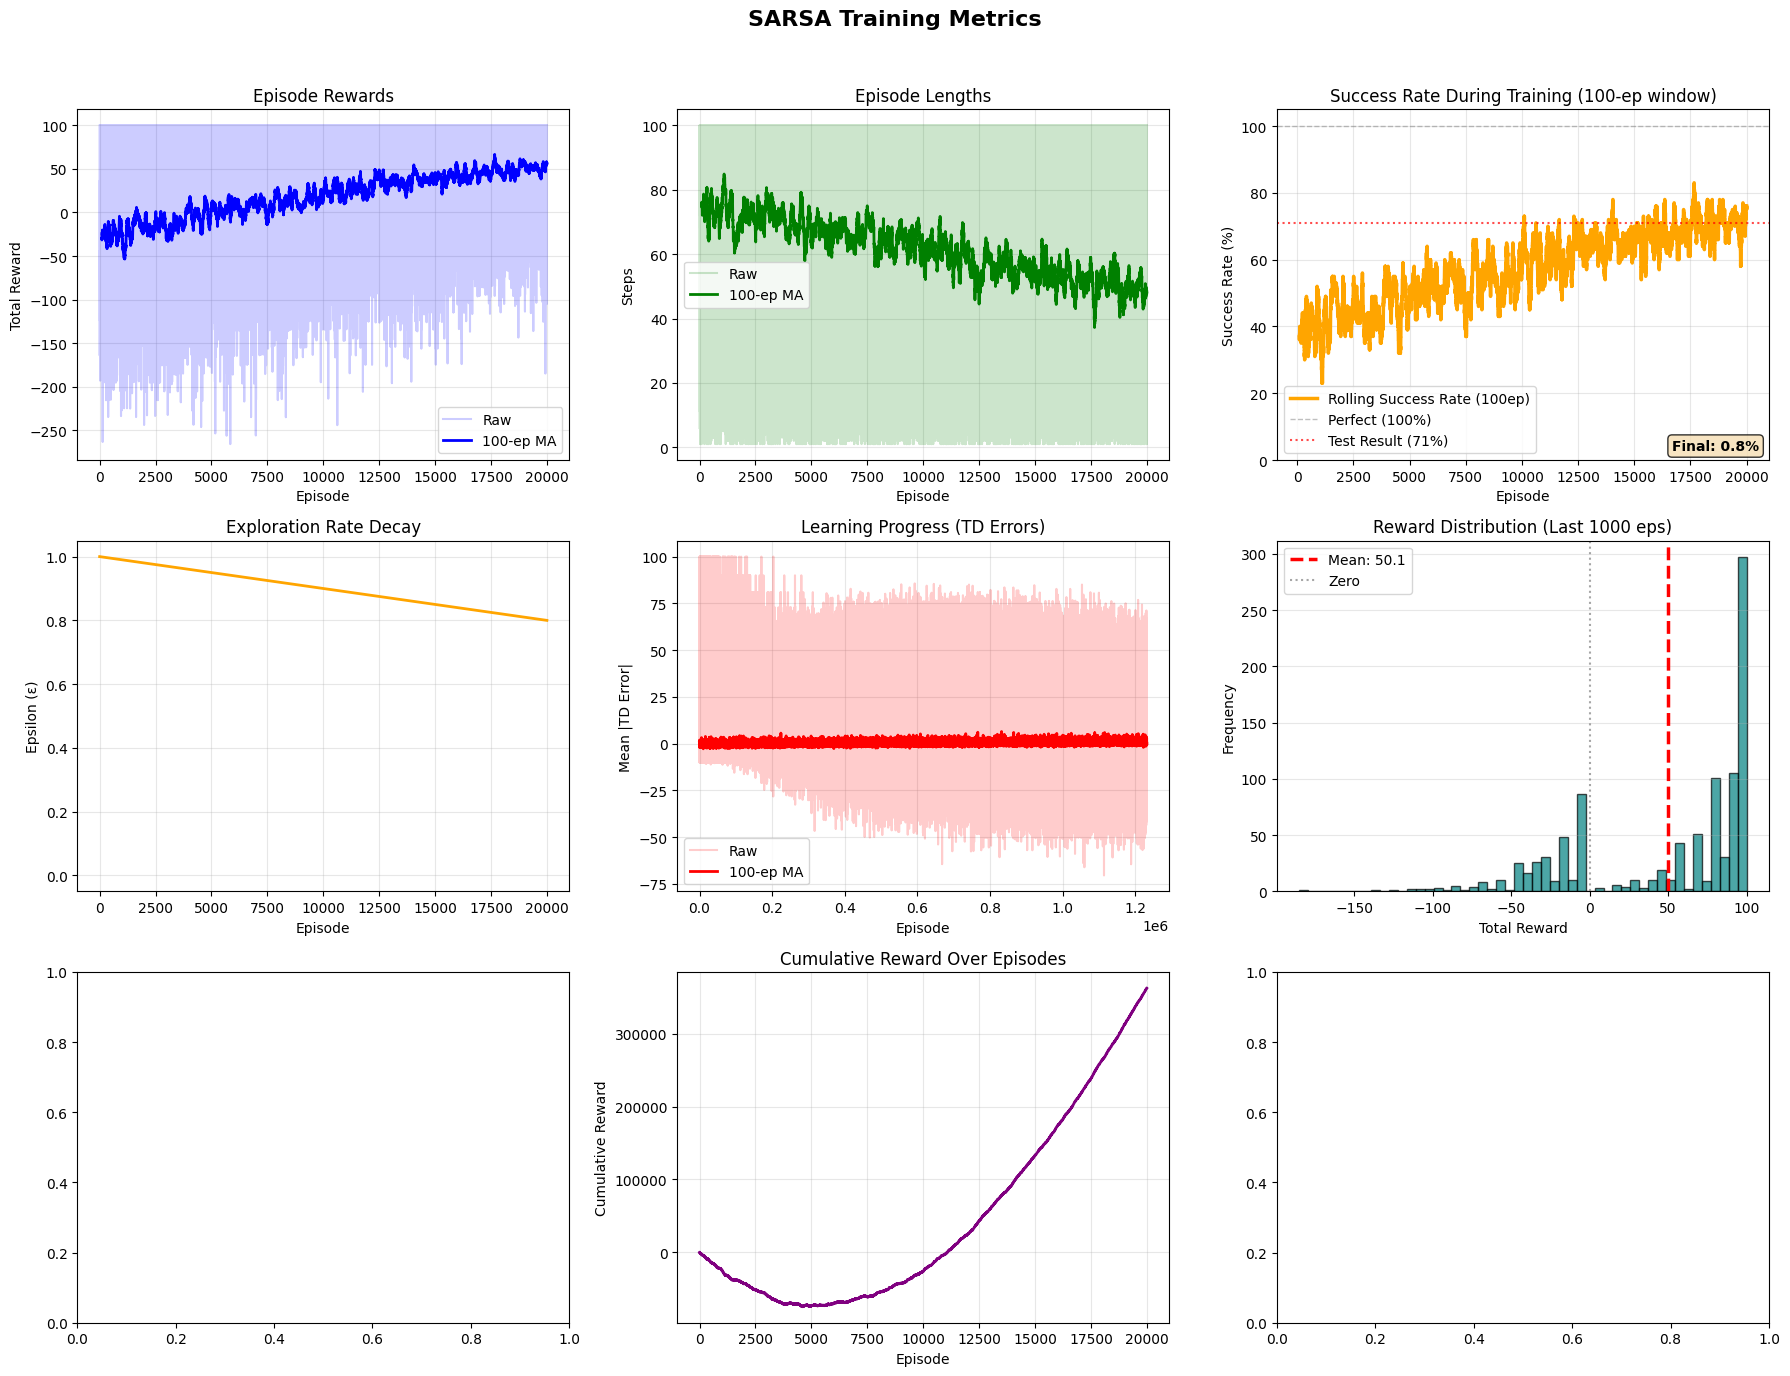


Testing... 



Testing: 100%|██████████| 10/10 [00:00<00:00, 171.48it/s]


TEST RESULTS (10 episodes)
Success Rate: 60.0%
Average Reward: 57.015 ± 52.560
Average Episode Len: 42.3 ± 47.2



=== Episode 1 ===
Driver at: [3 2], Destination at: [2 4]
Episode finished in 3 steps
Total reward: 99.97
Success: Yes

=== Episode 2 ===
Driver at: [7 3], Destination at: [2 1]
Episode finished in 100 steps
Total reward: -7.77
Success: No

=== Episode 3 ===
Driver at: [6 7], Destination at: [7 0]
Episode finished in 8 steps
Total reward: 99.72
Success: Yes

=== Episode 4 ===
Driver at: [0 4], Destination at: [6 5]
Episode finished in 100 steps
Total reward: -7.78
Success: No

=== Episode 5 ===
Driver at: [4 5], Destination at: [7 2]
Episode finished in 6 steps
Total reward: 99.87
Success: Yes

=== Episode 6 ===
Driver at: [4 1], Destination at: [7 1]
Episode finished in 5 steps
Total reward: 99.92
Success: Yes

=== Episode 7 ===
Driver at: [3 6], Destination at: [6 3]
Episode finished in 6 steps
Total reward: 99.87
Success: Yes

=== Episode 8 ===
Driver at: [3 5], Destination at: [7 5]
Episode finished in 4 steps
Total reward: 99.94
Success: Yes

=== Episode 9 ===
Driver at: [1 5], D

In [27]:
print("\nTraining...\n")

train_results = train_agent(agent, env, n_episodes)
print(f"Training success rate: {train_results['overall_success_rate']:.1%}")

visualize_training(train_results, agent, n_episodes, window=100, algo_name='SARSA', save_path='sarsa_training_metrics.png')

print("\nTesting... \n")
test_results = test_agent(agent, env, 10)

visualize_testing_progress(agent, MapEnv, n_episodes=10)




In [28]:
# Summary

print("\n" + "="*70)
print("SARSA SUMMARY")
print("="*70)
print(f"Training Episodes:  {n_episodes:}")
print(f"States Explored:    {len(agent.q_values):}")
print(f"Total Updates:      {len(agent.training_error):}")
print(f"Final Epsilon:      {agent.epsilon:.5f}")
print("="*70)

env.close()


SARSA SUMMARY
Training Episodes:  20000
States Explored:    3136
Total Updates:      1231356
Final Epsilon:      0.80000


#Testing epsilon

In [29]:
def test_epsilon_strategy(
    env,
    n_episodes,
    learning_rate,
    initial_epsilon,
    epsilon_decay,
    final_epsilon,
    discount_factor,
    strategy_name,
    train_agent,
    visualize=True
):
    # Test a specific epsilon strategy using custom training method
    print(f"\n{'='*70}")
    print(f"Testing Strategy: {strategy_name}")
    print(f"{'='*70}")
    print(f"Config: ε_initial={initial_epsilon}, ε_final={final_epsilon}, decay={epsilon_decay}")

    # Create agent
    agent = SARSAAgent(
        env=env,
        learning_rate=learning_rate,
        initial_epsilon=initial_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount_factor,
    )

    print("\nTraining...")
    results = train_agent(agent, env, n_episodes)

    episode_rewards = results["episode_rewards"]
    episode_lengths = results["episode_lengths"]
    epsilon_history = results.get("epsilon_history", [])
    success_rate_history = results["success_rate_history"]

    print(f"\nTraining completed. States explored: {len(agent.q_values)}")
    print(f"Final epsilon: {agent.epsilon:.4f}")

    # Test agent
    print("\nTesting trained agent...")
    test_results = test_agent(agent, env, 100)

    return {
        "name": strategy_name,
        "agent": agent,
        "episode_rewards": episode_rewards,
        "episode_lengths": episode_lengths,
        "epsilon_history": epsilon_history,
        "success_rate_history": success_rate_history,
        "test_success_rate": test_results["success_rate"],
        "test_avg_reward": test_results["avg_reward"],
        "test_avg_length": test_results["avg_length"],
        "final_epsilon": epsilon_history[-1],
        "avg_epsilon": np.mean(epsilon_history),
        "states_explored": len(agent.q_values),
    }


In [30]:
def visualize_strategy_comparison(results, n_episodes):

    fig, axes = plt.subplots(3, 3, figsize=(20, 12))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    axes = axes.flatten()

    colors = {'red': '#ef4444', 'orange': '#f97316', 'green': '#22c55e', 'blue': '#3b82f6'}
    window = 100

    # 1. Epsilon Decay Curves
    for result in results:
        axes[0].plot(result['epsilon_history'], label=result['name'],
                     color=colors[result['color']], linewidth=2, alpha=0.8)
    axes[0].set_xlabel('Episode', fontsize=11)
    axes[0].set_ylabel('Epsilon (ε)', fontsize=11)
    axes[0].set_title('Epsilon Decay Schedule', fontsize=13, fontweight='bold')
    axes[0].legend(fontsize=9)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(-0.05, 1.05)

    # 2. Episode Rewards
    for result in results:
        if len(result['episode_rewards']) > window:
            smoothed = np.convolve(result['episode_rewards'], np.ones(window)/window, mode='valid')
            axes[1].plot(range(window-1, len(result['episode_rewards'])), smoothed,
                        label=result['name'], color=colors[result['color']], linewidth=2, alpha=0.8)

    axes[1].set_xlabel('Episode', fontsize=11)
    axes[1].set_ylabel('Reward', fontsize=11)
    axes[1].set_title(f'Episode Rewards ({window}-episode Moving Avg)', fontsize=13, fontweight='bold')
    axes[1].legend(fontsize=9)
    axes[1].grid(True, alpha=0.3)

    # 3. Success Rate Over Time
    for result in results:
        if result['success_rate_history']:
            axes[2].plot(range(99, len(result['episode_rewards'])), result['success_rate_history'],
                        label=result['name'], color=colors[result['color']], linewidth=2, alpha=0.8)

    axes[2].set_xlabel('Episode', fontsize=11)
    axes[2].set_ylabel('Success Rate', fontsize=11)
    axes[2].set_title('Rolling Success Rate (100 episodes)', fontsize=13, fontweight='bold')
    axes[2].legend(fontsize=9)
    axes[2].grid(True, alpha=0.3)
    axes[2].set_ylim(-0.05, 1.05)

    # 4. Episode Lengths
    for result in results:
        if len(result['episode_lengths']) > window:
            smoothed = np.convolve(result['episode_lengths'], np.ones(window)/window, mode='valid')
            axes[3].plot(range(window-1, len(result['episode_lengths'])), smoothed,
                        label=result['name'], color=colors[result['color']], linewidth=2, alpha=0.8)
    axes[3].set_xlabel('Episode', fontsize=11)
    axes[3].set_ylabel('Steps', fontsize=11)
    axes[3].set_title(f'Episode Length ({window}-episode Moving Avg)', fontsize=13, fontweight='bold')
    axes[3].legend(fontsize=9)
    axes[3].grid(True, alpha=0.3)

    # 5. Test Performance Bar Chart
    names = [r['name'] for r in results]
    success_rates = [r['test_success_rate'] * 100 for r in results]
    bar_colors = [colors[r['color']] for r in results]
    bars = axes[4].bar(range(len(names)), success_rates, color=bar_colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    axes[4].set_xticks(range(len(names)))
    axes[4].set_xticklabels([n.split(' ')[0] for n in names], fontsize=10)
    axes[4].set_ylabel('Success Rate (%)', fontsize=11)
    axes[4].set_title('Final Test Performance', fontsize=13, fontweight='bold')
    axes[4].grid(True, alpha=0.3, axis='y')
    axes[4].set_ylim(0, 105)

    # Add value labels on bars
    for bar, rate in zip(bars, success_rates):
        axes[4].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

    # 6. Average Episode Length Comparison
    avg_lengths = [r['test_avg_length'] for r in results]
    bars = axes[5].bar(range(len(names)), avg_lengths, color=bar_colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    axes[5].set_xticks(range(len(names)))
    axes[5].set_xticklabels([n.split(' ')[0] for n in names], fontsize=10)
    axes[5].set_ylabel('Average Steps', fontsize=11)
    axes[5].set_title('Average Steps to Goal (Lower is Better)', fontsize=13, fontweight='bold')
    axes[5].grid(True, alpha=0.3, axis='y')

    # Add value labels
    for bar, length in zip(bars, avg_lengths):
        axes[5].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                f'{length:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

    # 7. Exploration vs Exploitation Timeline
    ax = plt.subplot2grid((3, 3), (2, 0), colspan=3)
    episodes = np.arange(0, n_episodes, 100)

    for i, result in enumerate(results):
        epsilon_sampled = [result['epsilon_history'][min(e, len(result['epsilon_history'])-1)] for e in episodes]
        exploitation = [(1 - e) * 100 for e in epsilon_sampled]

        if i == 0:
            ax.fill_between(episodes, 0, exploitation, label=result['name'],
                           color=colors[result['color']], alpha=0.3)
        ax.plot(episodes, exploitation, label=result['name'],
                color=colors[result['color']], linewidth=2.5, alpha=0.9)

    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Exploitation %', fontsize=12)
    ax.set_title('Exploitation Rate Over Time (Higher = More Learning from Best Actions)',
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=10, loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-5, 105)

    '''
    # Add explanation text
    explanation = (
        "Key Insight: Strategies that reach high exploitation faster (50-70%+) perform better\n"
        "because the agent spends more time using its learned knowledge rather than random exploration."
    )
    ax.text(0.5, 0.02, explanation, transform=ax.transAxes,
            fontsize=10, ha='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    '''

    plt.suptitle('SARSA Epsilon Strategy Comparison', fontsize=16, fontweight='bold', y=0.995)

    plt.savefig('epsilon_strategy_comparison.png', dpi=300, bbox_inches='tight')
    print("\nVisualization saved.")
    plt.show()


def print_comparison_summary(results):
    #summary
    print("\n" + "="*100)
    print("COMPARISON SUMMARY")
    print("="*100)
    print(f"{'Strategy':<30} {'Success Rate':<15} {'Avg Steps':<15} {'Final ε':<15} {'Avg ε':<15}")
    print("-"*100)

    for result in results:
        print(f"{result['name']:<30} "
              f"{result['test_success_rate']:.1%}{'':>10} "
              f"{result['test_avg_length']:<15.1f} "
              f"{result['final_epsilon']:<15.4f} "
              f"{result['avg_epsilon']:<15.4f}")

    print("="*100)

    # Find best strategy
    best_idx = np.argmax([r['test_success_rate'] for r in results])
    best = results[best_idx]

    print(f"\nWINNER: {best['name']}")
    print(f"\nSuccess Rate: {best['test_success_rate']:.1%}")
    print(f"\nAvg Steps: {best['test_avg_length']:.1f}")
    print(f"\nFinal Epsilon: {best['final_epsilon']:.4f}")
    print("="*100 + "\n")


In [31]:
def compare_epsilon_strategies(env, n_episodes=20000):

    print("="*70)
    print("SARSA EPSILON STRATEGY COMPARISON")
    print("="*70)
    print(f"Environment: {env.size}×{env.size} grid")
    print(f"Training episodes: {n_episodes}")
    print("="*70)

    # Define strategies to test
    strategies = [
        {
            'name': 'Current (Too Slow)',
            'decay': 1e-5,
            'final_epsilon': 0.01,
            'color': 'red'
        },
        {
            'name': 'Aggressive',
            'decay': (1.0 - 0.01) / (n_episodes * 0.3),
            'final_epsilon': 0.01,
            'color': 'orange'
        },
        {
            'name': 'Balanced (Recommended)',
            'decay': (1.0 - 0.05) / (n_episodes * 0.5),
            'final_epsilon': 0.05,
            'color': 'green'
        },
        {
            'name': 'Conservative',
            'decay': (1.0 - 0.1) / (n_episodes * 0.7),
            'final_epsilon': 0.1,
            'color': 'blue'
        }
    ]

    results = []

    for strategy in strategies:
        result = test_epsilon_strategy(
            env=env, n_episodes=n_episodes, learning_rate=0.1, initial_epsilon=1.0,
            epsilon_decay=strategy['decay'], final_epsilon=strategy['final_epsilon'],
            discount_factor=0.95, strategy_name=strategy['name'], train_agent=train_agent, visualize=False)

        result['color'] = strategy['color']

        results.append(result)

    # Visualize comparison
    visualize_strategy_comparison(results, n_episodes)

    # Print summary
    print_comparison_summary(results)

    return results

SARSA EPSILON STRATEGY COMPARISON
Environment: 8×8 grid
Training episodes: 20000

Testing Strategy: Current (Too Slow)
Config: ε_initial=1.0, ε_final=0.01, decay=1e-05

Training...

Training for 20000 episodes...



Training:  25%|██▌       | 5035/20000 [00:39<01:58, 126.67it/s]


Episode 5000/20000
  Avg Reward: -4.37
  Success Rate: 36.0%
  Avg Steps: 69.1
  Epsilon: 0.9500
  States: 3136


Training:  50%|█████     | 10016/20000 [01:15<01:24, 118.65it/s]


Episode 10000/20000
  Avg Reward: 23.50
  Success Rate: 63.0%
  Avg Steps: 60.4
  Epsilon: 0.9000
  States: 3136


Training:  75%|███████▌  | 15033/20000 [01:47<00:26, 187.79it/s]


Episode 15000/20000
  Avg Reward: 37.07
  Success Rate: 67.0%
  Avg Steps: 55.4
  Epsilon: 0.8500
  States: 3136


Training: 100%|██████████| 20000/20000 [02:16<00:00, 146.74it/s]



Episode 20000/20000
  Avg Reward: 49.55
  Success Rate: 73.0%
  Avg Steps: 49.7
  Epsilon: 0.8000
  States: 3136

Training complete. States explored: 3136
Final epsilon: 0.8000
Overall Success Rate: 57.0%

Training completed. States explored: 3136
Final epsilon: 0.8000

Testing trained agent...


Testing: 100%|██████████| 100/100 [00:00<00:00, 283.89it/s]



TEST RESULTS (100 episodes)
Success Rate: 63.0%
Average Reward: 60.087 ± 52.002
Average Episode Len: 39.5 ± 46.4

Testing Strategy: Aggressive
Config: ε_initial=1.0, ε_final=0.01, decay=0.000165

Training...

Training for 20000 episodes...



Training:  25%|██▌       | 5047/20000 [00:27<01:07, 222.84it/s]


Episode 5000/20000
  Avg Reward: 69.45
  Success Rate: 68.0%
  Avg Steps: 36.6
  Epsilon: 0.1750
  States: 3136


Training:  50%|█████     | 10072/20000 [00:41<00:26, 372.03it/s]


Episode 10000/20000
  Avg Reward: 88.60
  Success Rate: 88.0%
  Avg Steps: 18.3
  Epsilon: 0.0100
  States: 3136


Training:  76%|███████▌  | 15140/20000 [00:50<00:06, 708.20it/s]


Episode 15000/20000
  Avg Reward: 96.80
  Success Rate: 97.0%
  Avg Steps: 10.6
  Epsilon: 0.0100
  States: 3136


Training: 100%|██████████| 20000/20000 [00:55<00:00, 357.96it/s]



Episode 20000/20000
  Avg Reward: 98.67
  Success Rate: 100.0%
  Avg Steps: 8.4
  Epsilon: 0.0100
  States: 3136

Training complete. States explored: 3136
Final epsilon: 0.0100
Overall Success Rate: 84.9%

Training completed. States explored: 3136
Final epsilon: 0.0100

Testing trained agent...


Testing: 100%|██████████| 100/100 [00:00<00:00, 645.15it/s]



TEST RESULTS (100 episodes)
Success Rate: 96.0%
Average Reward: 95.531 ± 20.757
Average Episode Len: 11.0 ± 18.7

Testing Strategy: Balanced (Recommended)
Config: ε_initial=1.0, ε_final=0.05, decay=9.499999999999999e-05

Training...

Training for 20000 episodes...



Training:  25%|██▌       | 5032/20000 [00:32<01:17, 193.44it/s]


Episode 5000/20000
  Avg Reward: 57.79
  Success Rate: 70.0%
  Avg Steps: 46.1
  Epsilon: 0.5250
  States: 3136


Training:  50%|█████     | 10077/20000 [00:51<00:29, 332.22it/s]


Episode 10000/20000
  Avg Reward: 75.71
  Success Rate: 78.0%
  Avg Steps: 29.5
  Epsilon: 0.0500
  States: 3136


Training:  75%|███████▌  | 15069/20000 [01:04<00:09, 544.25it/s]


Episode 15000/20000
  Avg Reward: 87.08
  Success Rate: 87.0%
  Avg Steps: 19.2
  Epsilon: 0.0500
  States: 3136


Training: 100%|██████████| 20000/20000 [01:14<00:00, 269.56it/s]



Episode 20000/20000
  Avg Reward: 93.13
  Success Rate: 94.0%
  Avg Steps: 13.4
  Epsilon: 0.0500
  States: 3136

Training complete. States explored: 3136
Final epsilon: 0.0500
Overall Success Rate: 77.1%

Training completed. States explored: 3136
Final epsilon: 0.0500

Testing trained agent...


Testing: 100%|██████████| 100/100 [00:00<00:00, 405.79it/s]



TEST RESULTS (100 episodes)
Success Rate: 86.0%
Average Reward: 84.939 ± 36.827
Average Episode Len: 19.8 ± 32.6

Testing Strategy: Conservative
Config: ε_initial=1.0, ε_final=0.1, decay=6.428571428571429e-05

Training...

Training for 20000 episodes...



Training:  25%|██▌       | 5028/20000 [00:30<01:17, 192.52it/s]


Episode 5000/20000
  Avg Reward: 54.47
  Success Rate: 67.0%
  Avg Steps: 48.0
  Epsilon: 0.6786
  States: 3136


Training:  50%|█████     | 10055/20000 [00:52<00:33, 300.38it/s]


Episode 10000/20000
  Avg Reward: 71.31
  Success Rate: 81.0%
  Avg Steps: 34.1
  Epsilon: 0.3571
  States: 3136


Training:  75%|███████▌  | 15081/20000 [01:07<00:14, 336.88it/s]


Episode 15000/20000
  Avg Reward: 77.71
  Success Rate: 85.0%
  Avg Steps: 27.0
  Epsilon: 0.1000
  States: 3136


Training: 100%|██████████| 20000/20000 [01:20<00:00, 249.79it/s]



Episode 20000/20000
  Avg Reward: 84.16
  Success Rate: 93.0%
  Avg Steps: 21.3
  Epsilon: 0.1000
  States: 3136

Training complete. States explored: 3136
Final epsilon: 0.1000
Overall Success Rate: 73.6%

Training completed. States explored: 3136
Final epsilon: 0.1000

Testing trained agent...


Testing: 100%|██████████| 100/100 [00:00<00:00, 365.47it/s]



TEST RESULTS (100 episodes)
Success Rate: 82.0%
Average Reward: 80.609 ± 40.997
Average Episode Len: 23.2 ± 36.1

Visualization saved.


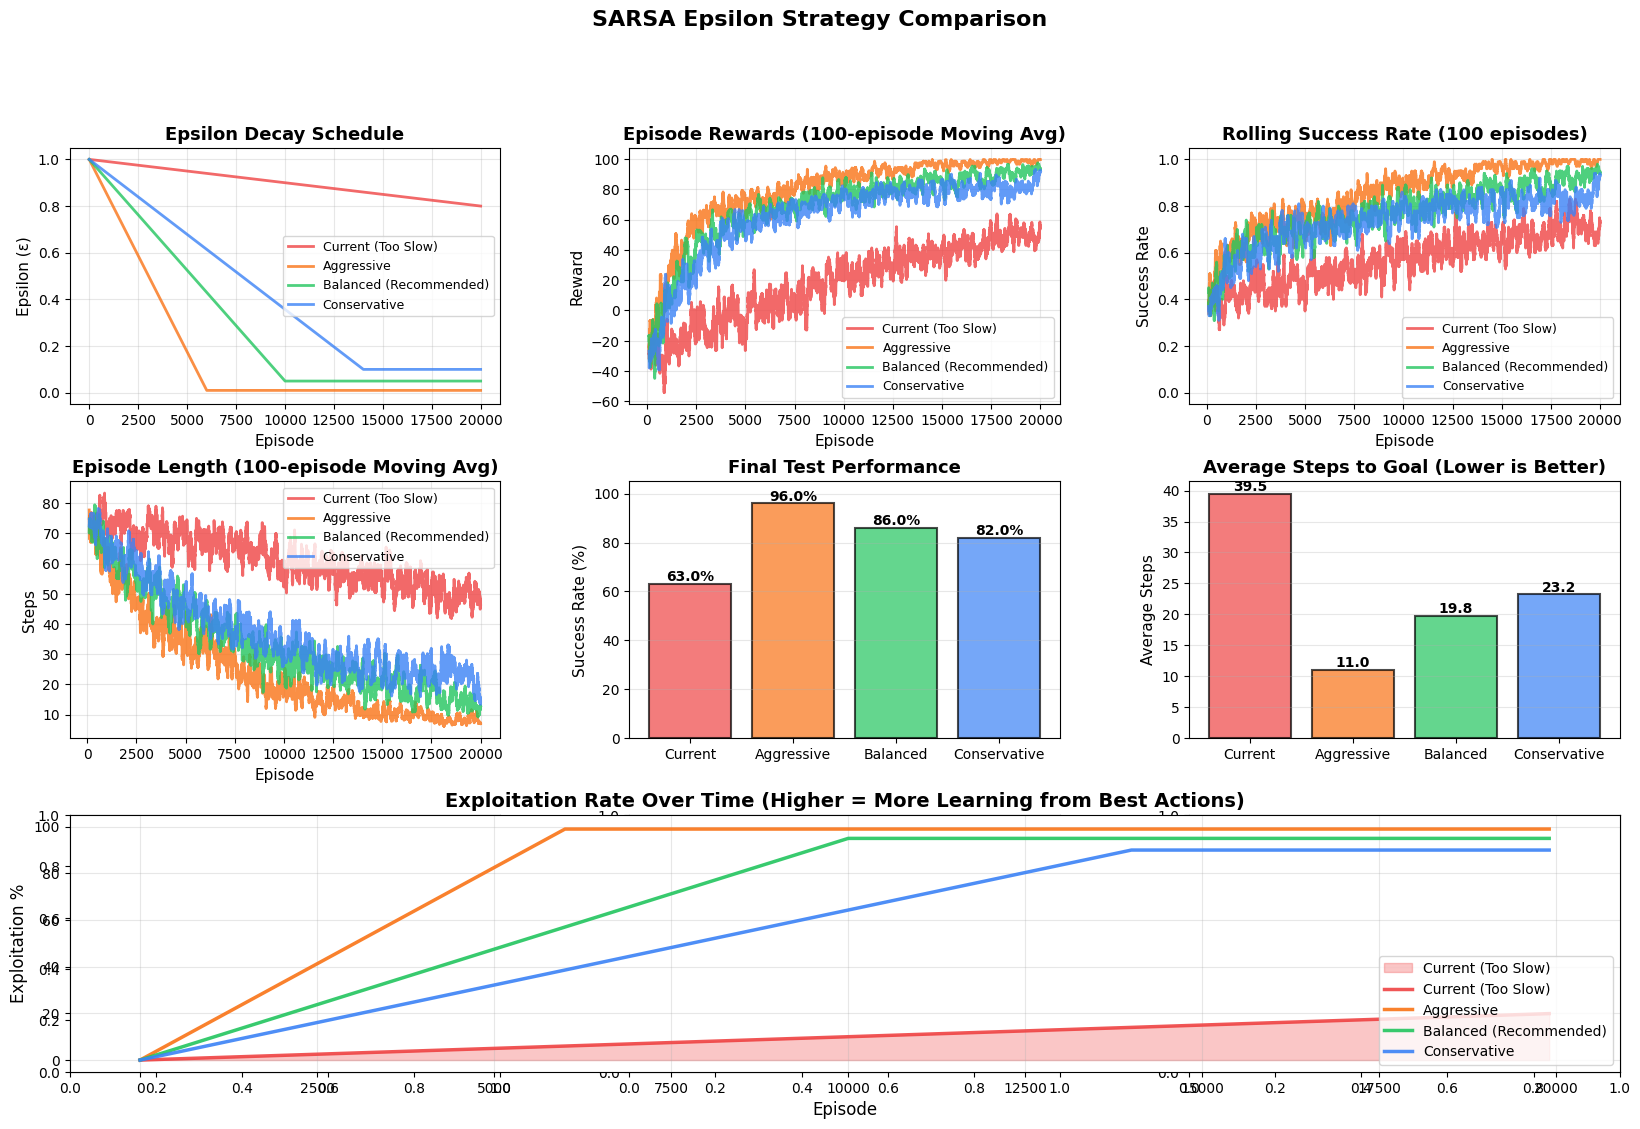


COMPARISON SUMMARY
Strategy                       Success Rate    Avg Steps       Final ε         Avg ε          
----------------------------------------------------------------------------------------------------
Current (Too Slow)             63.0%           39.5            0.8000          0.9000         
Aggressive                     96.0%           11.0            0.0100          0.1585         
Balanced (Recommended)         86.0%           19.8            0.0500          0.2875         
Conservative                   82.0%           23.2            0.1000          0.4150         

WINNER: Aggressive

Success Rate: 96.0%

Avg Steps: 11.0

Final Epsilon: 0.0100



In [32]:
env = MapEnv(render_mode=None)

results = compare_epsilon_strategies(env, n_episodes=20000)